   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1 

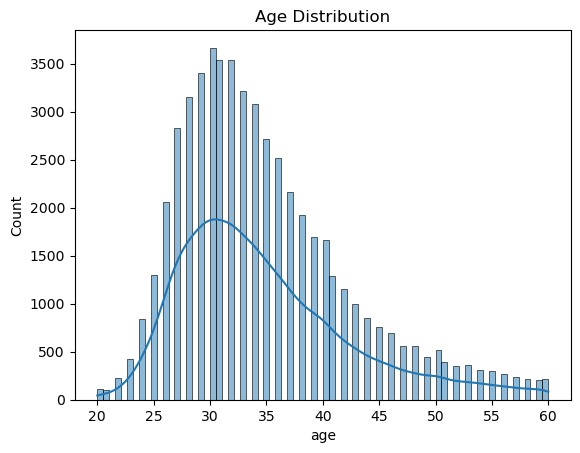

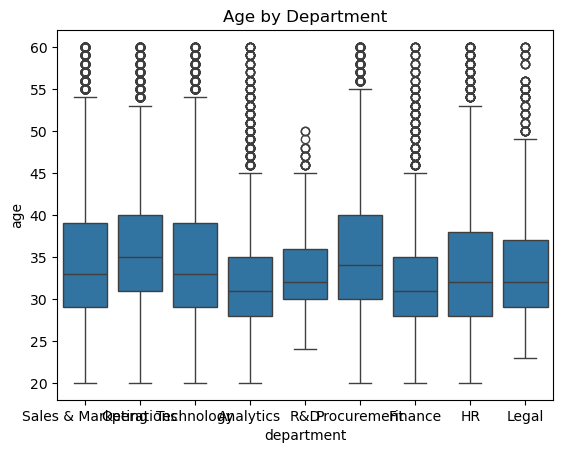

Logistic Regression Performance:
Accuracy: 0.9389
Precision: 0.9722
Recall: 0.2698
F1 Score: 0.4224


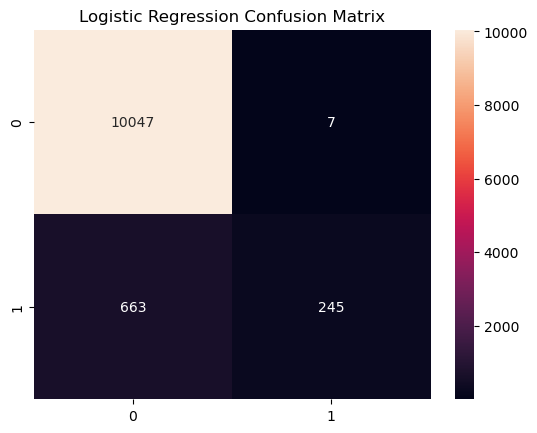

Random Forest Classifier Performance:
Accuracy: 0.9346
Precision: 0.8032
Recall: 0.2786
F1 Score: 0.4137


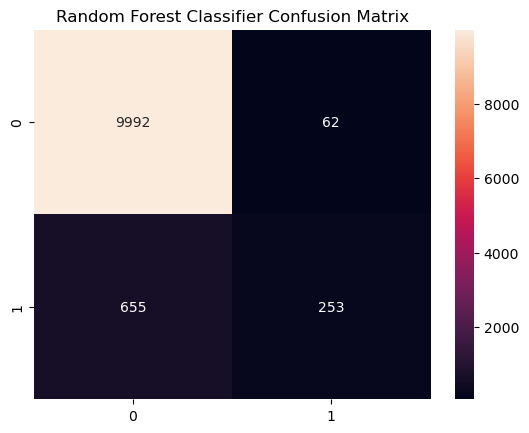

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the data

train_df = pd.read_csv(r"C:\Users\Raseena\Downloads\train_LZdllcl.csv")
test_df = pd.read_csv(r"C:\Users\Raseena\Downloads\test_2umaH9m.csv")
sample_submission = pd.read_csv(r"C:\Users\Raseena\Downloads\sample_submission_M0L0uXE.csv")

# EDA
print(train_df.head())
print(train_df.info())
print(train_df.describe())

# Visualizations
sns.histplot(train_df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(x='department', y='age', data=train_df)
plt.title('Age by Department')
plt.show()

# Pre-processing
numeric_features = ['age', 'length_of_service', 'avg_training_score', 'no_of_trainings', 'previous_year_rating']
categorical_features = ['department', 'education', 'gender', 'recruitment_channel', 'region']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply pre-processing separately to train and test datasets
X_train = train_df.drop(columns=['is_promoted', 'employee_id'])
y_train = train_df['is_promoted']

X_test = test_df.drop(columns=['employee_id'])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Modeling
# Split the training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

# Model 1: Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_split, y_train_split)
y_val_pred_log_reg = log_reg.predict(X_val)

# Model 2: Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_split, y_train_split)
y_val_pred_rf_clf = rf_clf.predict(X_val)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

evaluate_model(y_val, y_val_pred_log_reg, 'Logistic Regression')
evaluate_model(y_val, y_val_pred_rf_clf, 'Random Forest Classifier')

# Fine-tuning with GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

best_rf_clf = grid_search.best_estimator_
y_val_pred_best_rf = best_rf_clf.predict(X_val)

# Evaluate the fine-tuned model
evaluate_model(y_val, y_val_pred_best_rf, 'Tuned Random Forest')

# Making Predictions on the test data
y_test_pred = best_rf_clf.predict(X_test_processed)

# Update the sample submission file with predictions
sample_submission['is_promoted'] = y_test_pred

# Save the updated dataset as a new CSV file
sample_submission.to_csv('sample_data.csv', index=False)
